In [2]:
# first test for polyphonic music
import librosa
import numpy as np
import os
from sporco.admm import cbpdn
import sporco.metric as sm
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelextrema
import scipy.io.wavfile
sr = 11025

In [22]:
# load the dictionary
D = []
directory = './maps/notes/'

for i in range(21,109):
    fname1 = 'MAPS_ISOL_NO_F_S0_M' + str(i) + '_SptkBGCl.wav'
    fname2 = 'MAPS_ISOL_NO_F_S1_M' + str(i) + '_SptkBGCl.wav'
    
    try:
        s = librosa.load(directory + fname1, sr=11025,offset=0.7,duration=1.0)[0]
    except:
        s = librosa.load(directory + fname2, sr=11025,offset=0.7,duration=1.0)[0]
    # normalize dictionary elements
    D.append(s/np.amax(s))
    
D = np.asarray(D)
D = D.T

with open('mapsdict.pkl','wb') as fid:
     pickle.dump(D,fid)

In [ ]:
#solve the CBPDN problem
with open('mapsdict.pkl','rb') as fid:
    D = pickle.load(fid)
print(D.shape)
lmbda = 0.005
# 1 temporal dimension
dimN = 1

opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 500,
                    'HighMemSolve' : True, 'LinSolveCheck' : True,
                    'RelStopTol' : 1e-3, 'AuxVarObj' : False})

songdir = "./maps/songs/"
songname = "MAPS_MUS-alb_esp2_SptkBGCl.wav"
song, sr = librosa.load(songdir+songname,sr=sr,duration=30.0)

b = cbpdn.ConvBPDN(D, song, lmbda, opt,dimN=dimN)
X = b.solve()
X = X[:,0,0,:]
with open('maps_results_esp2.pkl', 'wb') as fid:
    pickle.dump(X, fid)

(11025, 88)
Itn   Fnc       DFid      Regℓ1     r         s         ρ         
----------------------------------------------------------------
   0  4.34e+00  3.84e+00  9.87e+01  1.00e+00  0.00e+00  1.25e+00
   1  4.27e+00  3.78e+00  9.86e+01  1.00e+00  0.00e+00  1.25e+00
   2  4.79e-01  3.91e-02  8.81e+01  3.87e-01  2.57e+00  1.25e+03
   3  7.01e-01  1.23e-02  1.38e+02  4.81e-01  6.95e-01  4.80e+02
   4  5.94e-01  8.11e-03  1.17e+02  4.41e-01  4.26e-01  3.95e+02
   5  4.96e-01  8.56e-03  9.75e+01  3.39e-01  2.86e-01  3.95e+02
   6  4.36e-01  8.11e-03  8.56e+01  2.49e-01  2.38e-01  3.95e+02
   7  3.89e-01  7.46e-03  7.64e+01  1.96e-01  2.07e-01  3.95e+02
   8  3.40e-01  7.19e-03  6.66e+01  1.56e-01  1.81e-01  3.95e+02
   9  3.04e-01  7.16e-03  5.94e+01  1.23e-01  1.61e-01  3.95e+02
  10  2.94e-01  7.09e-03  5.75e+01  1.11e-01  1.43e-01  3.40e+02
  11  2.85e-01  6.95e-03  5.57e+01  1.00e-01  1.29e-01  2.96e+02
  12  2.74e-01  6.79e-03  5.35e+01  9.14e-02  1.15e-01  2.58e+02
  13  2.64e

In [10]:
# load the GT
songdir = "./maps/songs/"
songname = "MAPS_MUS-alb_esp2_SptkBGCl.wav"
song, sr = librosa.load(songdir+songname,sr=sr,duration=5.0)

f = open(songdir + 'MAPS_MUS-alb_esp2_SptkBGCl.txt', 'rb')
lines = f.readlines()[1:]
GT = {}
for row in lines:
    row = row.decode().strip('\r\n')
    row = row.split('\t')
    if row[2] in GT:
        GT[row[2]].append([row[0], row[1]])
    else:
        GT[row[2]] = [[row[0], row[1]]]

In [11]:
with open('maps_results_esp2.pkl','rb') as Y:
    Y = pickle.load(Y)
    
duration = song.shape[0]/sr

lmaxes = np.asarray([])
for row in Y:
    relex = argrelextrema(row,np.greater)[0]
    lmaxes = np.concatenate((lmaxes,row[relex]))

p75,p25 = np.percentile(lmaxes, [75,25])
# try different values for iqr
threshold = p75 + 12*(p75-p25)
# lmaxes = np.sort(lmaxes)
# l = lmaxes.shape[0]
# threshold = lmaxes[95*int(l/100)]
# need to select proper threshold value
print('threshold is', threshold)
# new array of only below threshold
lowvals = Y < threshold
Y[lowvals] = 0

#duration of each window
window_size = 0.05
start = 0
l = int(sr*window_size)
end = l
window = 0
print('finding maxima')
# 2D array that represents onsets
onsets = np.zeros((88,int(duration/0.05)))
# keep track of highest note, low (for plotting purposes)
highnote = 0
lownote = 100
total=0
correct=0
for i in range(int(duration/window_size)):
    row = Y[start:end,:]
    #print(row.shape)
    sumrow = np.sum(row,axis=0)
    relex = argrelextrema(sumrow,np.greater)[0]
    if(len(relex) != 0):
        # time index that the note occurs
        high = np.amax(relex)
        low = np.amin(relex)
        if high > highnote:
            highnote = high
        if low < lownote:
            lownote = low
        tindex = window
        onsets[relex,tindex] = 1
        t = window_size * window
        for note in relex:
            note += 21
            total += 1
            if str(note) in GT:
                time_ranges = GT[str(note)]
                for time_range in time_ranges:
                    if t < float(time_range[0]) - 0.05:
                        break
                    elif t >= float(time_range[0]) - 0.05 and t <= float(time_range[1]) + 0.05:
                        correct += 1
                        break
        #print(relex+21, "{0:.2f}".format(t))
        #print('\n')
    start = end
    end += l
    window+=1

correct_percentage = float(correct) / total
print(total)
print ("Correct percentage is: " + str(correct_percentage))

threshold is 0.00183084793389
finding maxima
30
Correct percentage is: 0.8666666666666667


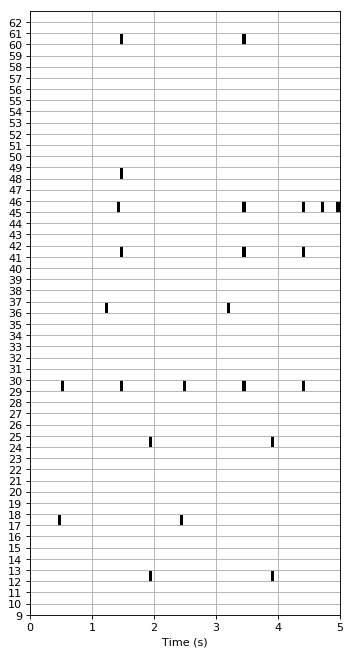

In [13]:
# peak is OK if it occurs within [onset - 0.05, offset+0.05]
#print(onsets.shape)
if lownote>3: low = lownote - 3
if highnote<85: high = highnote + 3
noterange = [low,high]
x = np.linspace(0,duration,num=int(duration/window_size),endpoint=True)
y = np.arange(0,88)

# make each note thing skinny
for i in range(onsets.shape[1]-1):
    curr = onsets[:,i]
    nxt = onsets[:,i+1]
    # take differnce of two frames
    chnge = nxt - curr
    # where chnge = 0, we want to set next to 0
    indices = chnge < 1
    onsets[indices,i+1] = 0
    
# set plot size
fig = plt.figure(num=None, figsize=(5, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1) 
major_ticks = np.arange(low,high)       
ax.set_yticks(major_ticks)
plt.pcolormesh(x,y,onsets,cmap='Greys')
# zoom in on the notes that are actually being played
plt.ylim(noterange)
plt.xlabel('Time (s)')
ax.grid(True)